- RandomForest, XGBoost는 다중공선성 제거가 필요없지만    
  Lasso는 선형 회귀 기반이라 다중공선성 제거를 해야 함 (L1이라 정규화는 하겠지만)   
- 로그 변환이 필요함 - 타겟 피쳐 + 왜도 > 1 피쳐(데이터 탐색에서 확인)

In [1]:
# 한글, 음수 시각화 설정

#시각화 패키지
import matplotlib.pyplot as plt

#시각화에서 한글을 사용하기 위한 설정
import platform
from matplotlib import font_manager, rc

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
    
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
    
#시각화에서 음수를 표현하기 위한 설정
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install xgboost

In [3]:
import pandas as pd 
import numpy as np
import re 

from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer
# from sklearn.linear_model import LassoCV
# from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df = pd.read_csv('../../data/prp_factory_glass_2016.csv', index_col= 0)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8142 entries, 2016-01-01 07 to 2016-12-31 23
Columns: 197 entries, LIFT.OUT.ROL.MTR.M.SPD to R.Vac
dtypes: float64(197)
memory usage: 12.3+ MB


,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,DB.N2.SCREEN.FLOW.LEFT,DB.N2.SCREEN.FLOW.RIGHT,N2.TO.EA1313A,ROOF.HEATING.Zone,...,STD.U.L,STD.U.R,STD.L.L,STD.L.R,STD.GLS.L,STD.GLS.R,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.040366,...,0.523950,1.951349,2.248106,2.767676,3.012706,3.069007,0.025,0.063,0.108,0.041
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.028982,...,0.566521,2.010125,2.364418,2.842630,3.022998,3.069274,0.000,0.022,0.133,0.000
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.065345,...,0.545936,2.002820,2.397034,2.817728,2.936967,2.969952,0.016,0.063,0.000,0.000
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.084378,...,0.549254,2.047995,2.399854,2.810619,2.876398,2.914596,0.000,0.103,0.000,0.000
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-1.514135,-1.529208,-0.218748,0.024016,...,0.610913,2.101178,2.379341,2.797094,2.858177,2.873929,0.000,0.000,0.000,0.000


> ### 왼쪽 공정만 추출

- 왼쪽 공정 중 L / l이 포함된 경우 lower과 겹칠 가능성이 있어 제외 안함

In [5]:
cols = df.columns

# 1. LEFT 키워드 , RIGHT 키워드
left_keyword_cols = [
    col for col in cols
    if re.search(r'(LEFT|U\.L|L\.L|u\.l|l\.l|L\.RD|L\.Vac)', col, flags=re.IGNORECASE)
]

right_keyword_cols = [
    col for col in cols
    if re.search(r'(RIGHT|U\.R|L\.R|u\.r|l\.r|R\.RD|R\.Vac|\.R\b)', col, flags=re.IGNORECASE)
]

# 2. 공통 공정 = LEFT도 아니고 RIGHT도 아닌 컬럼
common_cols = [col for col in cols if col not in left_keyword_cols and col not in right_keyword_cols]

# 데이터프레임 구성
left_feature_df = df[left_keyword_cols].copy()
right_feature_df = df[right_keyword_cols].copy()
common_feature_df = df[common_cols].copy()

# 결과 확인
print("✅ 왼쪽 공정 수:", len(left_feature_df.columns))
print("✅ 오른쪽 공정 수:", len(right_feature_df.columns))
print("✅ 공통 공정 수:", len(common_feature_df.columns))


✅ 왼쪽 공정 수: 30
✅ 오른쪽 공정 수: 42
✅ 공통 공정 수: 126


In [6]:
# 왼쪽 feature_df 구성
left_df = pd.concat([common_feature_df, left_feature_df], axis=1)
print("✅ 최종 왼쪽 feature_df 컬럼 수:", left_df.shape[1])


✅ 최종 왼쪽 feature_df 컬럼 수: 156


> ### 피쳐 - 타겟 분리

In [7]:
left_df.head()

,LIFT.OUT.ROL.MTR.M.SPD,LEHR.DRV.MTR.M.SPD,DRV.MTR.M.SPD,X,DCS.Offset.RPM.M,DAMP.POSITION.BAY.CTRL,N2.TO.EA1313A,ROOF.HEATING.Zone,ATM.FLOW.SECT.N2.H2,ATM.FLOW.SECT.N2,...,S.AB.AB.U.L,S.AB.AB.L.L,S.AB.C.U.L,S.AB.C.L.L,S.C.C.U.L,S.C.C.L.L,STD.U.L,STD.L.L,L.RD,L.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.742443,-1.699444,-1.683797,-0.755452,-1.947792,-1.251006,-0.218748,0.040366,-1.812108,0.172787,...,0.047915,-0.172226,0.146778,1.772574,1.405119,0.785430,0.523950,2.248106,0.025,0.063
2016-01-01 08,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.028982,-1.792364,0.252142,...,0.025103,-0.189845,0.161917,1.871182,1.433834,0.749426,0.566521,2.364418,0.000,0.022
2016-01-01 09,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.065345,-1.815574,0.283121,...,0.009143,-0.196662,0.153177,1.826206,1.446866,0.805319,0.545936,2.397034,0.016,0.063
2016-01-01 10,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.084378,-1.846923,0.157744,...,-0.018994,-0.201060,0.173210,1.853880,1.434837,0.751488,0.549254,2.399854,0.000,0.103
2016-01-01 11,-1.744941,-1.699677,-1.685770,-0.755452,-1.947792,-1.251006,-0.218748,0.024016,-1.855973,0.180923,...,-0.037802,-0.204591,0.163199,1.792980,1.447733,0.816928,0.610913,2.379341,0.000,0.000


In [8]:
feature_df = left_df.iloc[:, :-2]
feature_df.head()

target_df = left_df[['L.RD']] # 다른 변수들의 선형 결합이므로
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.025
2016-01-01 08,0.000
2016-01-01 09,0.016
2016-01-01 10,0.000
2016-01-01 11,0.000


In [9]:
# 1. NaN이 포함된 열만 추출
nan_cols = feature_df.columns[feature_df.isnull().any()]

# 2. 각 열별 NaN 개수 출력
nan_summary = feature_df[nan_cols].isnull().sum()

print("🔍 로그 변환 전 결측치 열:")
print(nan_summary.sort_values(ascending=False))

🔍 로그 변환 전 결측치 열:
Series([], dtype: float64)


> ### 로그 변환

- 피쳐 데이터 중 왜도 > 1
- 타겟 데이터

In [10]:
skewed_feats = feature_df.apply(skew)
skewed_cols = skewed_feats[abs(skewed_feats) > 1.0].index

In [11]:
feature_log_df = feature_df.copy()

In [12]:
# 사인 함수 + 로그 변환
def signed_log_transform(x):
    return np.sign(x) * np.log1p(np.abs(x))

# 적용
feature_df[skewed_cols] = feature_df[skewed_cols].apply(signed_log_transform)
target_df = target_df.apply(np.log1p)

In [13]:
# 변환 후 NaN 발생한 컬럼 확인
nan_cols = feature_log_df.columns[feature_log_df.isnull().any()]
print("🚨 변환 후 NaN 발생한 열:")
print(nan_cols)
print(len(nan_cols))

🚨 변환 후 NaN 발생한 열:
Index([], dtype='object')
0


In [14]:
target_df.head()

,L.RD
dat...date.name.,
2016-01-01 07,0.024693
2016-01-01 08,0.000000
2016-01-01 09,0.015873
2016-01-01 10,0.000000
2016-01-01 11,0.000000


> ### train-test 분리

In [15]:
X_train, X_test, y_train , y_test = train_test_split(feature_df, target_df, test_size=0.2, random_state= 42, )

print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)
print('y_train : ', y_train.shape)
print('y_test : ', y_test.shape)

X_train :  (6513, 154)
X_test :  (1629, 154)
y_train :  (6513, 1)
y_test :  (1629, 1)


> ### XGBoost 적용

In [16]:
xgboost_pipe = make_pipeline(
    StandardScaler(),
    XGBRegressor(n_estimators= 500, max_depth= 4, 
                 learning_rate= 0.05, random_state= 42)
)

xgboost_pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [17]:
xgboost_pipe.score(X_train, y_train) # 89.90%
xgboost_pipe.score(X_test, y_test) # 61.03%

0.6103390455245972

In [18]:
y_pred = xgboost_pipe.predict(X_test)

print("✅ RMSE:", mean_squared_error(y_test, y_pred, squared=False)) # 예측값 - 실제값 사이 평균 오차 
print("✅ R² score:", r2_score(y_test, y_pred)) # 전체 변동성 중 설명 가능한 변동성

# 피처 중요도 추출
importances = xgboost_pipe.named_steps['xgbregressor'].feature_importances_

# Series로 정리
selected_features = pd.Series(importances, index=X_train.columns)
selected_features = selected_features.sort_values(ascending=False)

# 상위 15개 중요 피처 출력
print("🎯 중요도가 높은 공정 피처 Top 15:")
print(selected_features.head(15))

✅ RMSE: 0.02371581937050899
✅ R² score: 0.6103390455245972
🎯 중요도가 높은 공정 피처 Top 15:
SPOUT.LEFT.BOTTOM                  0.142013
ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT    0.140898
l.n.glass                          0.052575
TMP.GLASS.LEFT.EXIT                0.036228
S.AB.C.L                           0.029779
re.btm.up.dn                       0.024370
cluster                            0.021121
S.AB.C.U.L                         0.019839
top                                0.018405
Ribbon.Speed                       0.018011
ROOF.HT.BAY.TOTAL.PWR.1CLBAY11     0.017099
rc.btm.up.dn                       0.014437
ROOF.HT.BAY.TOTAL.PWR.1CLBAY4      0.014188
S.C.RET.L                          0.013437
SPOUT.LEFT.UPSTREAM                0.012181
dtype: float32


> ### 주요 공정 분포 확인

In [19]:
main_features = selected_features.keys()[:30]
print(main_features)

Index(['SPOUT.LEFT.BOTTOM', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT', 'l.n.glass',
       'TMP.GLASS.LEFT.EXIT', 'S.AB.C.L', 're.btm.up.dn', 'cluster',
       'S.AB.C.U.L', 'top', 'Ribbon.Speed', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAY11',
       'rc.btm.up.dn', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAY4', 'S.C.RET.L',
       'SPOUT.LEFT.UPSTREAM', 'N2.TO.EA1313B', 'S.C.C.L.L',
       'BATH.AMBIENT.BAY.LEFT', 'DB.HEAT.BTM.LEFT.TMP',
       'X.BAY.LEFT.PRESSURE.CLBAY.LEFT', 'l.tin.bay', 'X.LEHR.O2.ANALYZER',
       'r.top.n.mean', 'N2.TO.EA1315B', 'le.re.btm.dn', 'STD.GLS.L',
       'DB.BTM.DN.STM.TC.C', 'ATM.FLOW.SECT.N2.PV', 'S.C.C.U.L',
       'TMP.GLASS.Z.RET.E2'],
      dtype='object')


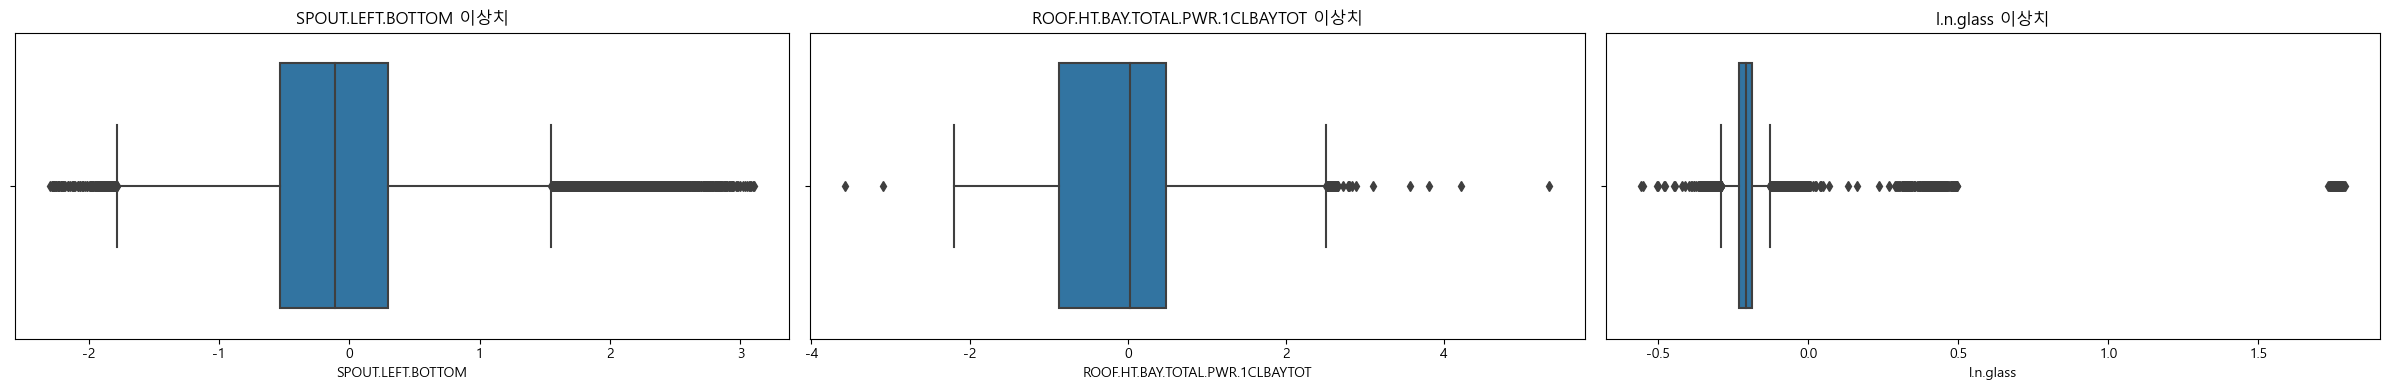

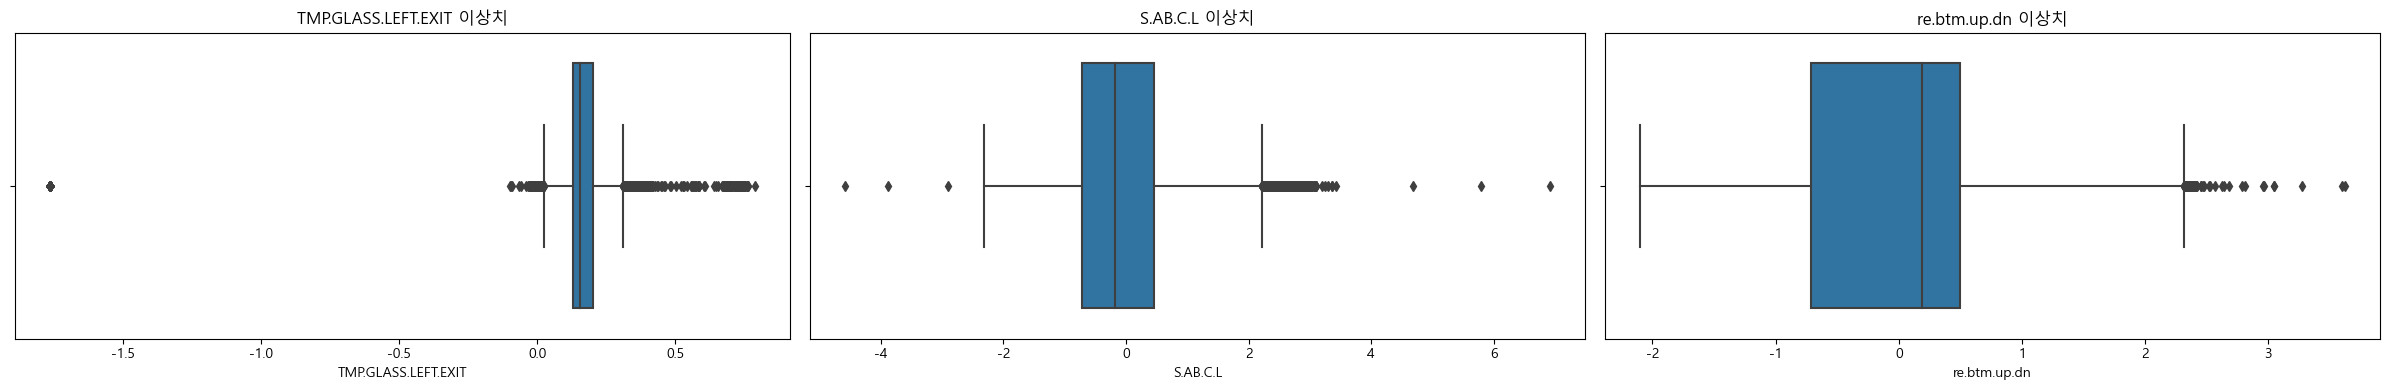

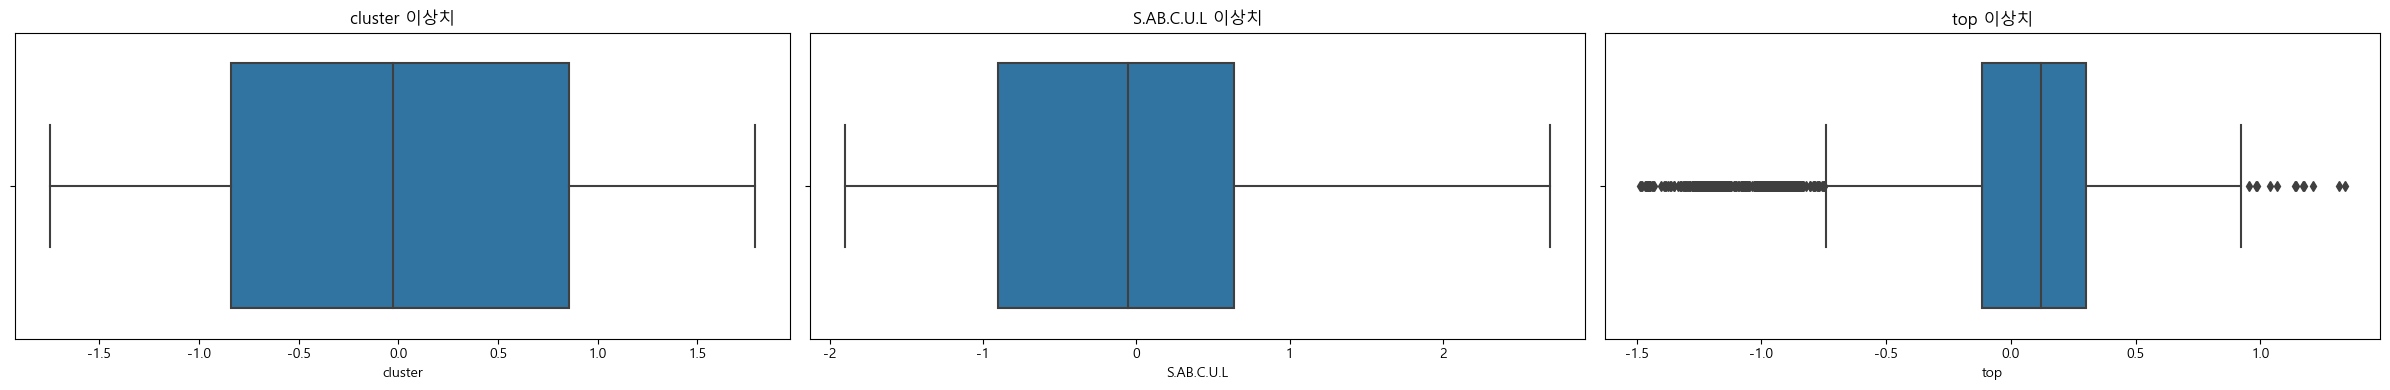

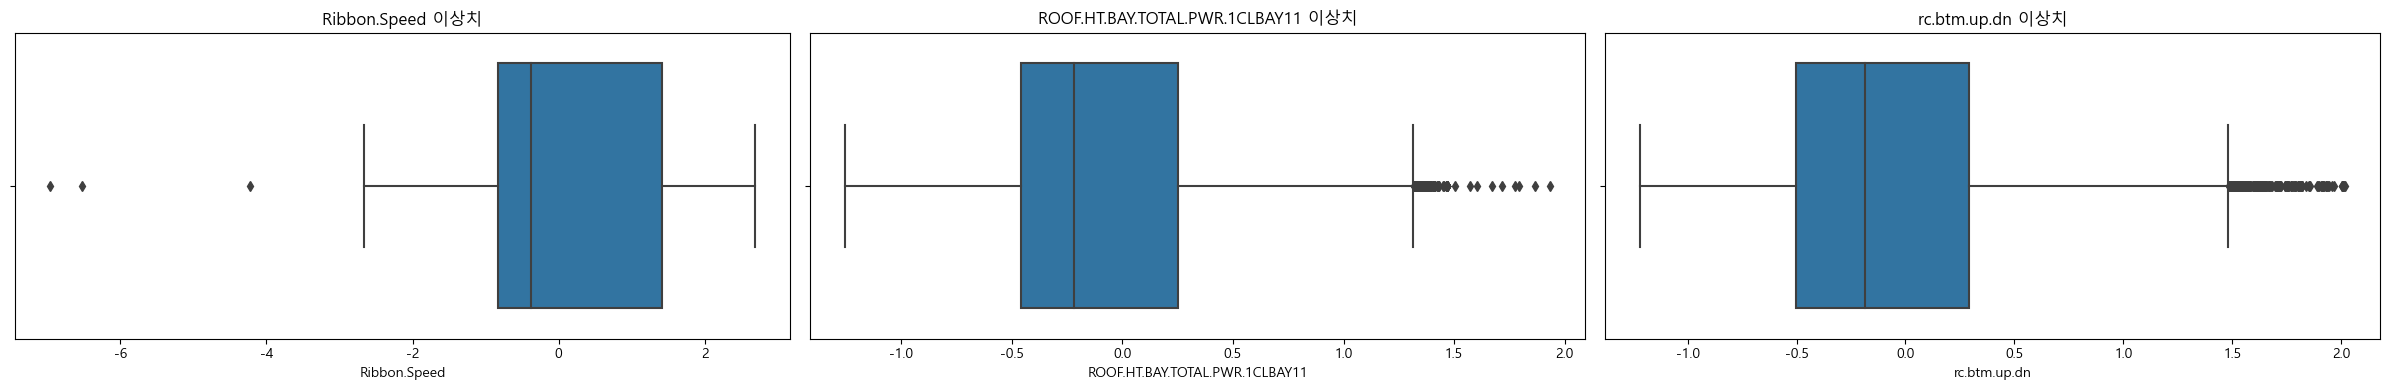

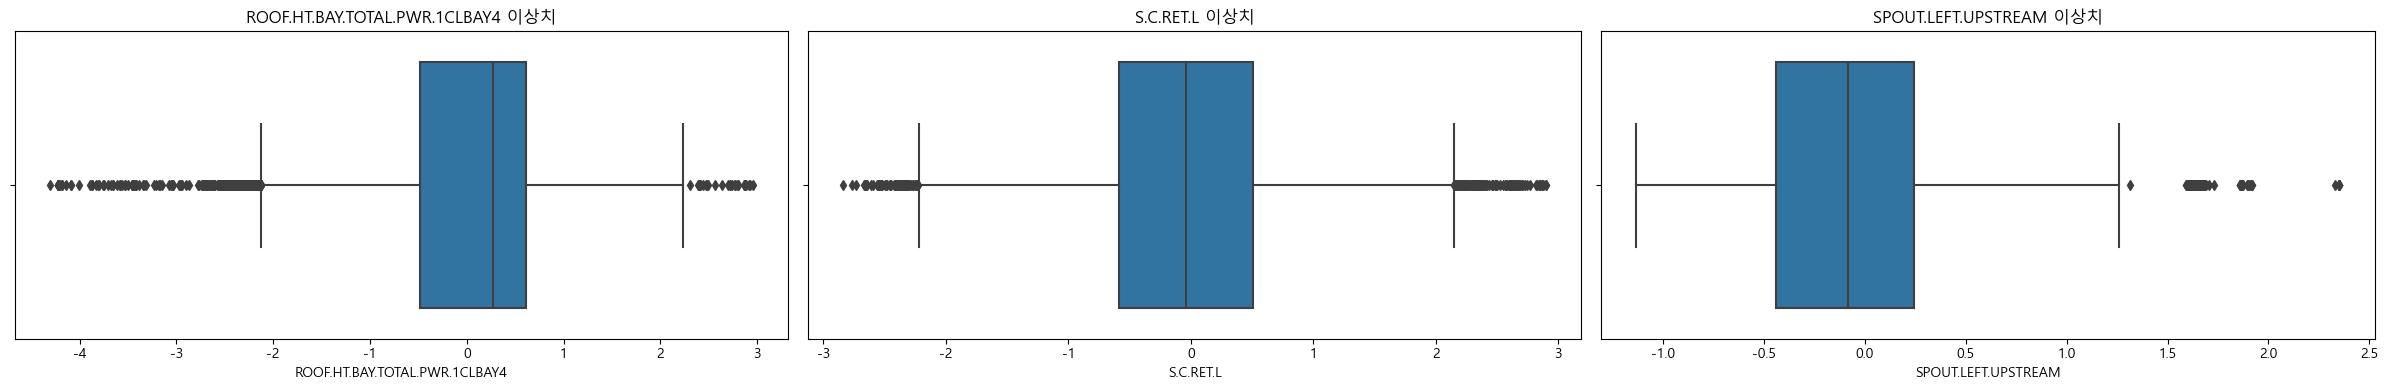

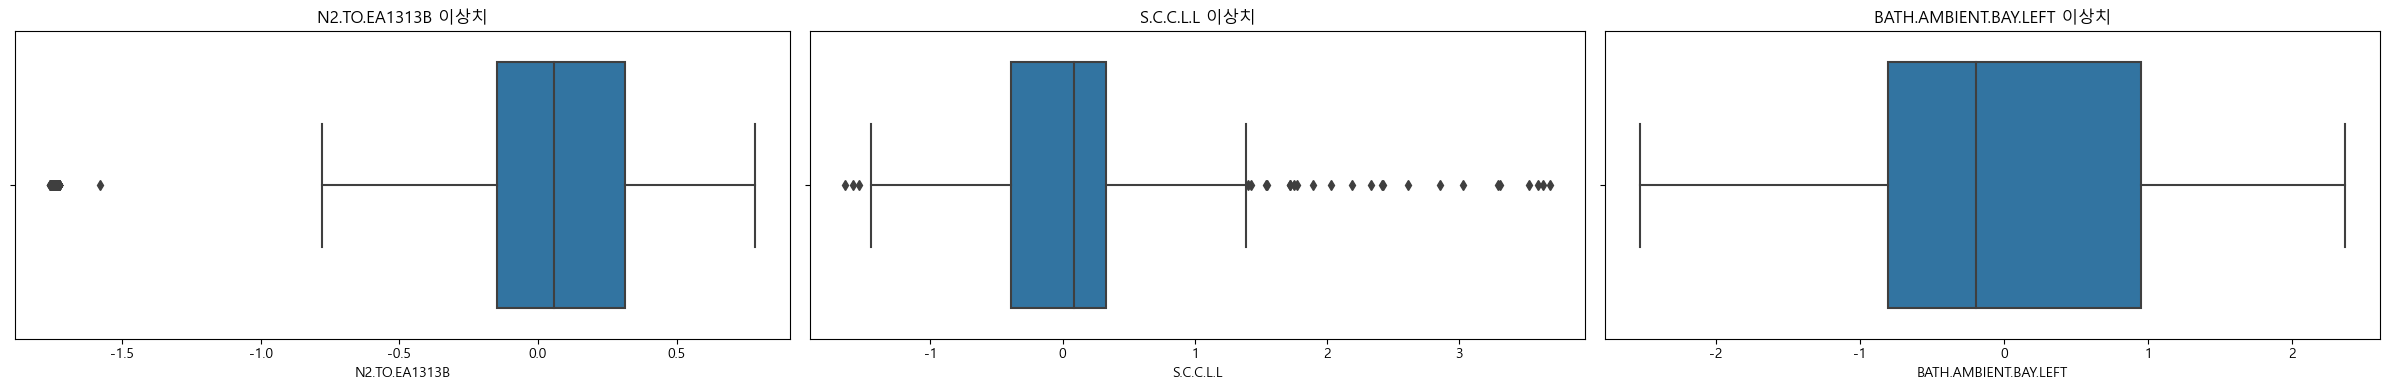

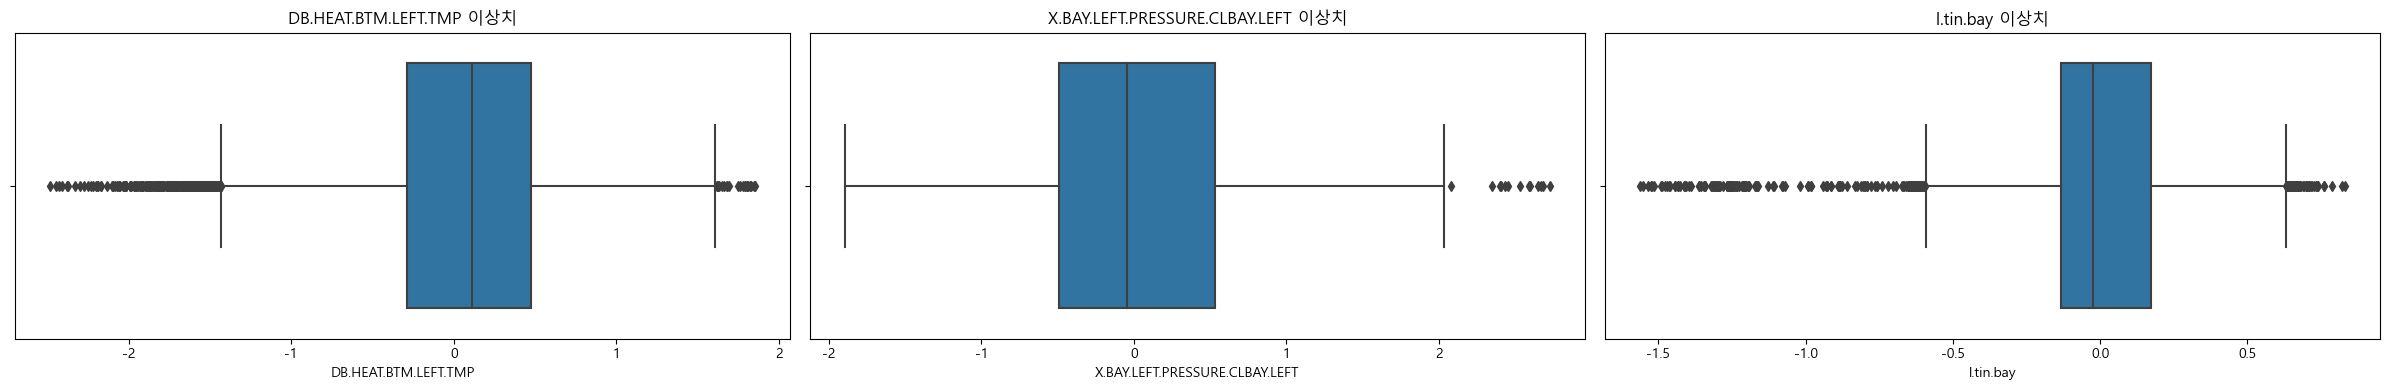

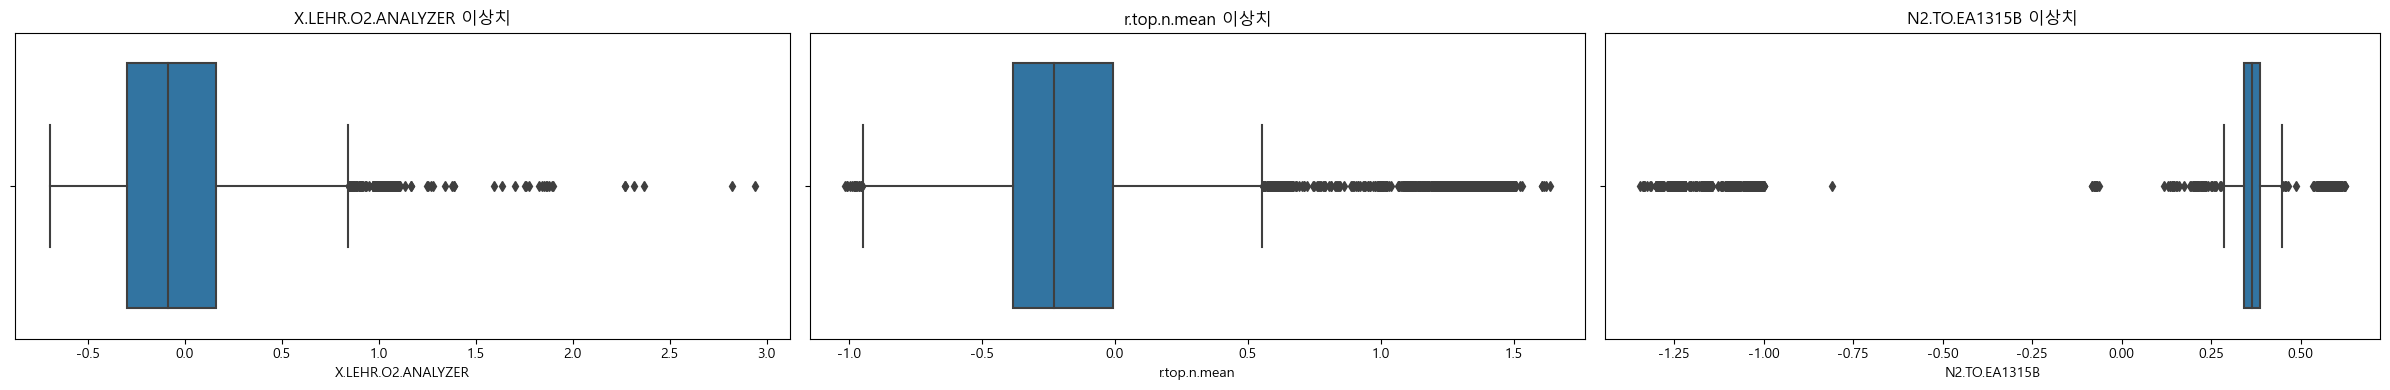

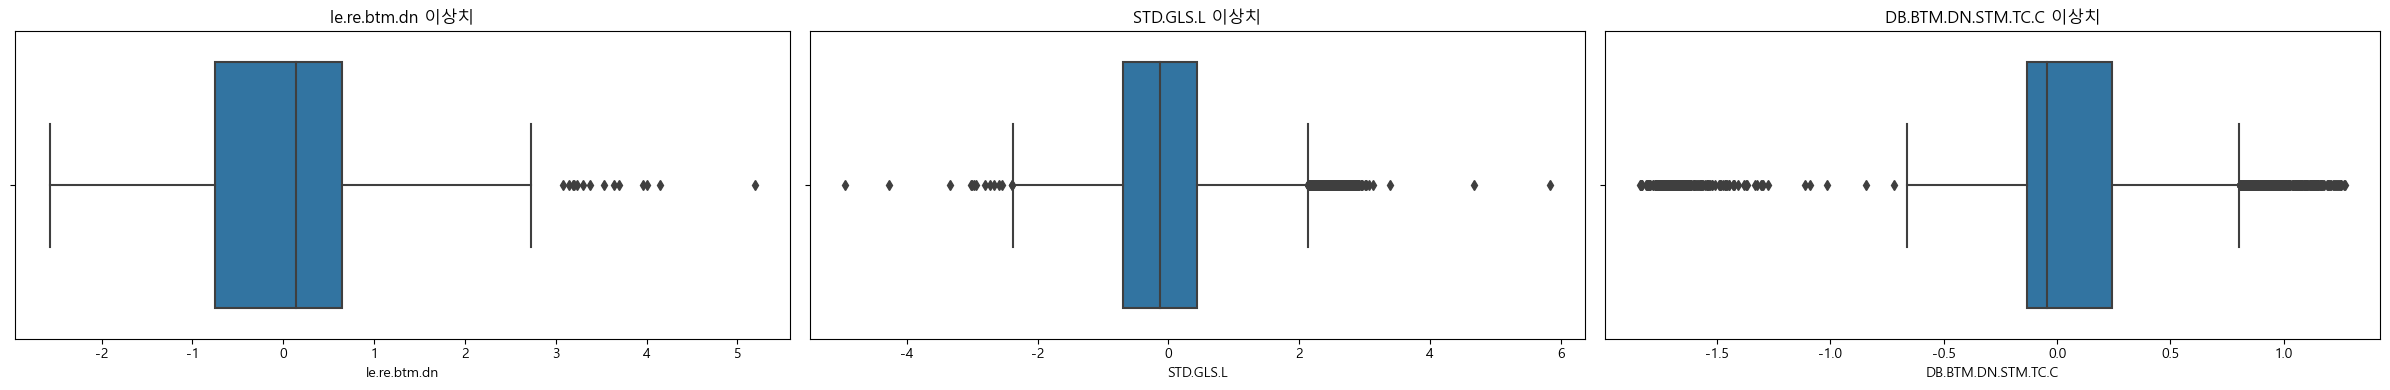

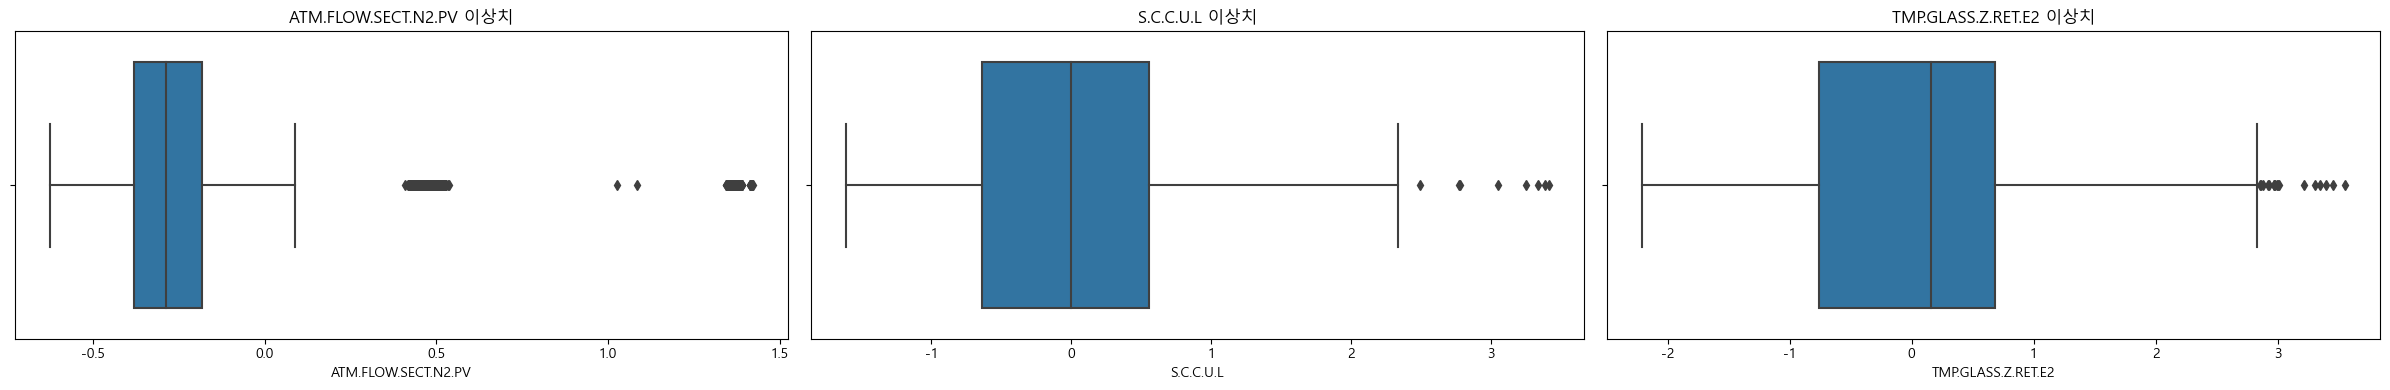

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

n_cols = 3  # 한 행에 3개씩
n_rows = math.ceil(len(main_features) / n_cols)

for i in range(0, len(main_features), n_cols):
    features_chunk = main_features[i:i + n_cols]
    fig, axes = plt.subplots(1, len(features_chunk), figsize=(8 * len(features_chunk), 4))

    if len(features_chunk) == 1:
        axes = [axes]  # 한 개일 경우도 리스트로 변환

    for ax, col in zip(axes, features_chunk):
        sns.boxplot(data=feature_df, x=col, ax=ax)
        ax.set_title(f"{col} 이상치")

    plt.tight_layout()
    plt.show()

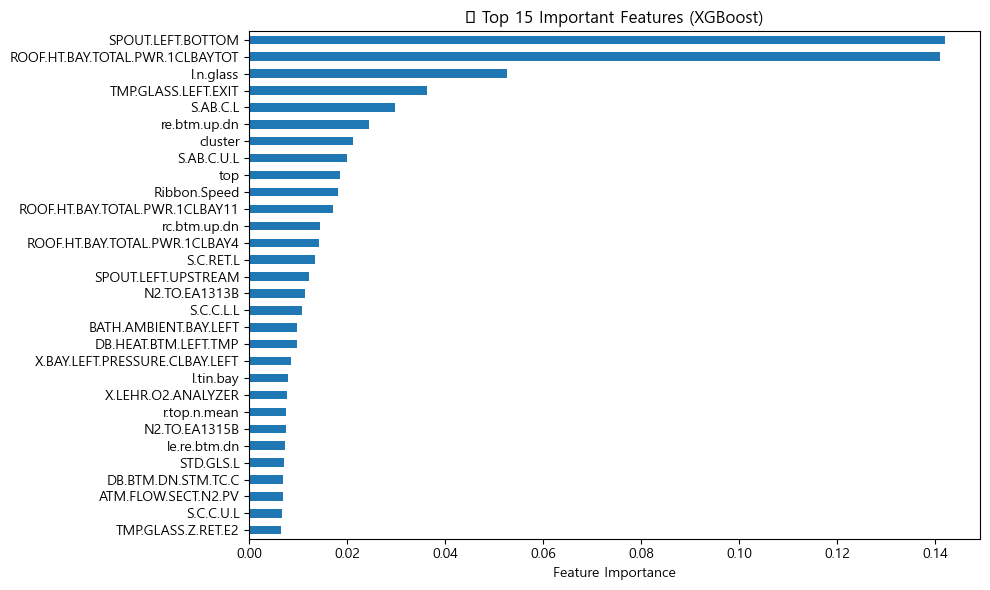

In [22]:
# 시각화: 상위 15개 피처 중요도
plt.figure(figsize=(10, 6))
selected_features.head(30).sort_values().plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("🎯 Top 15 Important Features (XGBoost)")
plt.tight_layout()
plt.show()

> ### 주요 공정별 실제 데이터 확인

In [34]:
print(selected_features)

SPOUT.LEFT.BOTTOM                  0.142013
ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT    0.140898
l.n.glass                          0.052575
TMP.GLASS.LEFT.EXIT                0.036228
S.AB.C.L                           0.029779
                                     ...   
TMP.GLASS.ZONE.F.E4                0.000723
E.L.DB.LEFT.N2.FLOW                0.000634
DAMP.POSITION.BAY.CTRL             0.000540
SEC11.N2.H2                        0.000101
SEC11.N2                           0.000000
Length: 154, dtype: float32


In [24]:
main_process = selected_features[selected_features > 0.02].keys()
main_process

Index(['SPOUT.LEFT.BOTTOM', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT', 'l.n.glass',
       'TMP.GLASS.LEFT.EXIT', 'S.AB.C.L', 're.btm.up.dn', 'cluster'],
      dtype='object')

In [25]:
import pandas as pd
import numpy as np

origin_df = pd.read_csv('../../data/factory_glass_2016.csv', encoding= 'cp949', index_col= 0)
origin_df.head()

,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,...,ROLLDOWN.폐기.RIGHT.,진공패드.폐기.RIGHT.,폐기율...,ROLLDOWN.진공패드.폐기율..LEFT.,ROLLDOWN.진공패드.폐기율..RIGHT.,ROLLDOWN.진공패드.폐기율..전체.,L.RD,L.Vac,R.RD,R.Vac
dat...date.name.,,,,,,,,,,,,,,,,,,,,,
2016-01-01 07,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,...,8,3,11.69,8.75,14.86,11.69,0.025,0.063,0.108,0.041
2016-01-01 08,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,...,10,0,7.19,2.17,13.33,7.19,0.000,0.022,0.133,0.000
2016-01-01 09,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,...,0,0,3.85,7.81,0.00,3.85,0.016,0.063,0.000,0.000
2016-01-01 10,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,...,0,0,4.96,10.29,0.00,4.96,0.000,0.103,0.000,0.000
2016-01-01 11,-1.772682,-1.713219,-1.734851,-1.590051,-1.636293,-1.575213,-1.636293,-1.548119,-1.824581,-1.548119,...,0,0,0.00,0.00,0.00,0.00,0.000,0.000,0.000,0.000


> ### 원래 공정명 찾기

In [26]:
# ['SPOUT.LEFT.BOTTOM', 'ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT', 'l.n.glass', 'TMP.GLASS.LEFT.EXIT', 'S.AB.C.L', 're.btm.up.dn', 'cluster']

spout_cols = [col for col in origin_df.columns if 'SPOUT.LEFT.BOTTOM' in col]

roof_cols = [col for col in origin_df.columns if 'ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT' in col]

glass_cols = [col for col in origin_df.columns if 'glass' in col]
glass_cols # ['l_r_glass', 'l_n.2_glass', 'r_n.2_glass']
glass_cols = ['l_n.2_glass']

left_exit_cols = [col for col in origin_df.columns if '.LEFT.EXIT' in col]

s_ab_cols = [col for col in origin_df.columns if 'S_AB' in col]
s_ab_cols
s_ab_cols = ['S_AB7_C4_L']

re_btm_cols = [col for col in origin_df.columns if 'up_dn' in col]
re_btm_cols
re_btm_cols = ['re_btm_up_dn']

cluster_cols = [col for col in origin_df.columns if 'cluster' in col]
cluster_cols

origin_main_process = sum([
    spout_cols, roof_cols, glass_cols, left_exit_cols, 
    s_ab_cols, re_btm_cols, cluster_cols
], [])

origin_main_process

['SPOUT.LEFT.BOTTOM.1FI33513.PV',
 'ROOF.HT.BAY.TOTAL.PWR.1CLBAYTOT_CPV',
 'l_n.2_glass',
 'TMP.GLASS..LEFT.EXIT.1TIC30109.PV',
 'S_AB7_C4_L',
 're_btm_up_dn',
 'cluster']

In [63]:
origin_main_process_df = origin_df[origin_main_process]
origin_main_process_df
origin_main_process_df.to_csv('../../data/main_process_df.csv', index= True)